In this notebook we implement the algorithm from the following articles:
- Wu, Y., Rosca, M., & Lillicrap, T. (2019). Deep compressed sensing
- Dhar, M., Grover, A., & Ermon, S. (2018). Modeling sparse deviations for compressed sensing using generative models
- Bora, A., Jalal, A., Price, E., & Dimakis, A. G. (2017, August). Compressed sensing using generative models

We illustrate the results on the Fashion MNIST dataset

In [212]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import matplotlib.animation as animation
from IPython.display import HTML
import os
import cvxpy
import pickle 

import torch
from torchvision.utils import save_image, make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using GPU" if device.type=="cuda" else "using CPU" )

# homemade code
from utils import import_data, plot_recovery, show
from vae import train_vae, VAE, VAEcnn
from cs import generate, generate_sparse, get_score
from lasso import generate_bp, generate_lasso
from gan import GeneratorNet

using GPU


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

# Data

We work on the Fashion Mnist dataset. Similarly to the MNIST dataset it has 10 classes and 28*28 gray images

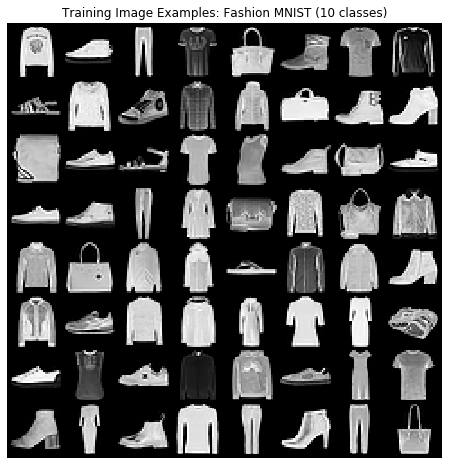

In [198]:
batch_size = 128
train_loader, test_loader = import_data("fashion", batch_size, plot=True, binary=False, normalize=False)

# VAE 

We first train a VAE with latent dimension 100 a two different architectures.
- A fully connected with exactly the same architecure as in the articles: 784-500-500-100 for the encoder and 100-500-500-784 for the decoder
- A convonlutional VAE with convolution layers for the encoder and deconvolution layers for the decoders.

Creation of the directory results/vae_fashion_z100 failed
Train Epoch: 1 [0/60000 (0%)]	Loss: 544.642395
Train Epoch: 1 [32000/60000 (53%)]	Loss: 291.212677
====> Epoch: 1 Average loss: 296.8564
====> Test set loss: 266.9523
Train Epoch: 2 [0/60000 (0%)]	Loss: 259.721710
Train Epoch: 2 [32000/60000 (53%)]	Loss: 252.453751
====> Epoch: 2 Average loss: 259.3810
====> Test set loss: 256.4032
Train Epoch: 3 [0/60000 (0%)]	Loss: 255.479691
Train Epoch: 3 [32000/60000 (53%)]	Loss: 245.476120
====> Epoch: 3 Average loss: 251.5595
====> Test set loss: 251.3651
Train Epoch: 4 [0/60000 (0%)]	Loss: 246.373199
Train Epoch: 4 [32000/60000 (53%)]	Loss: 232.705734
====> Epoch: 4 Average loss: 248.3060
====> Test set loss: 248.7682
Train Epoch: 5 [0/60000 (0%)]	Loss: 246.817459
Train Epoch: 5 [32000/60000 (53%)]	Loss: 255.994766
====> Epoch: 5 Average loss: 246.3435
====> Test set loss: 247.4270
Train Epoch: 6 [0/60000 (0%)]	Loss: 251.023361
Train Epoch: 6 [32000/60000 (53%)]	Loss: 255.545288
====> Ep

Train Epoch: 49 [32000/60000 (53%)]	Loss: 235.943359
====> Epoch: 49 Average loss: 236.2108
====> Test set loss: 238.7288
Train Epoch: 50 [0/60000 (0%)]	Loss: 245.942322
Train Epoch: 50 [32000/60000 (53%)]	Loss: 229.148117
====> Epoch: 50 Average loss: 236.1761
====> Test set loss: 238.9554


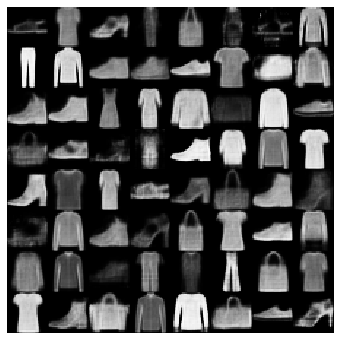

In [4]:
train_vae(100, 50, device, train_loader, test_loader, name='vae_fashion_z100')

Creation of the directory results/vae_cnn_fashion_z100 failed
Train Epoch: 1 [0/60000 (0%)]	Loss: 543.532593
Train Epoch: 1 [32000/60000 (53%)]	Loss: 345.007446
====> Epoch: 1 Average loss: 341.2720
====> Test set loss: 283.4156
Train Epoch: 2 [0/60000 (0%)]	Loss: 281.607178
Train Epoch: 2 [32000/60000 (53%)]	Loss: 262.406799
====> Epoch: 2 Average loss: 269.3845
====> Test set loss: 261.8059
Train Epoch: 3 [0/60000 (0%)]	Loss: 257.458405
Train Epoch: 3 [32000/60000 (53%)]	Loss: 258.844574
====> Epoch: 3 Average loss: 255.7319
====> Test set loss: 254.0688
Train Epoch: 4 [0/60000 (0%)]	Loss: 243.400848
Train Epoch: 4 [32000/60000 (53%)]	Loss: 254.041397
====> Epoch: 4 Average loss: 250.3336
====> Test set loss: 250.2376
Train Epoch: 5 [0/60000 (0%)]	Loss: 252.510117
Train Epoch: 5 [32000/60000 (53%)]	Loss: 257.808746
====> Epoch: 5 Average loss: 247.4860
====> Test set loss: 248.3490
Train Epoch: 6 [0/60000 (0%)]	Loss: 247.902267
Train Epoch: 6 [32000/60000 (53%)]	Loss: 241.385605
====

Train Epoch: 49 [32000/60000 (53%)]	Loss: 223.952759
====> Epoch: 49 Average loss: 235.1595
====> Test set loss: 239.7713
Train Epoch: 50 [0/60000 (0%)]	Loss: 237.563217
Train Epoch: 50 [32000/60000 (53%)]	Loss: 239.242966
====> Epoch: 50 Average loss: 235.0967
====> Test set loss: 239.6955


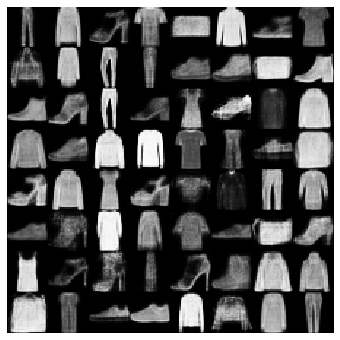

In [5]:
train_vae(100, 50, device, train_loader, test_loader, name='vae_cnn_fashion_z100',cnn=True)

# GAN

We give up the use of GAN for generative models they are too unstable. In the following cells you can see examples of failed traning. The GAN only generates some of the numbers, was say that it has collapsed.

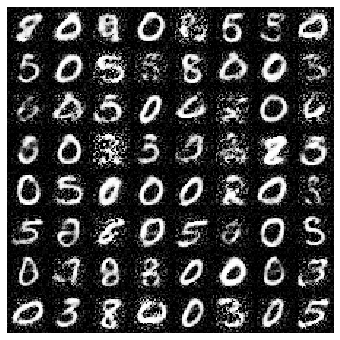

In [215]:
noise = lambda size: torch.randn(size, 100)
vectors_to_images = lambda vectors: vectors.view(vectors.size(0), 1, 28, 28)

num_test_samples = 64
test_noise = noise(num_test_samples)

state_dict = torch.load("save/generator_GAN_z100.pth", map_location=device)
model = GeneratorNet().to(device)
model.load_state_dict(state_dict)
model = model.eval()

img_list = vectors_to_images(model(test_noise.to(device)))
img_list = torch.clamp(img_list,0,1)
show(make_grid(img_list.view(64, 1, 28, 28).detach(), padding=0))  

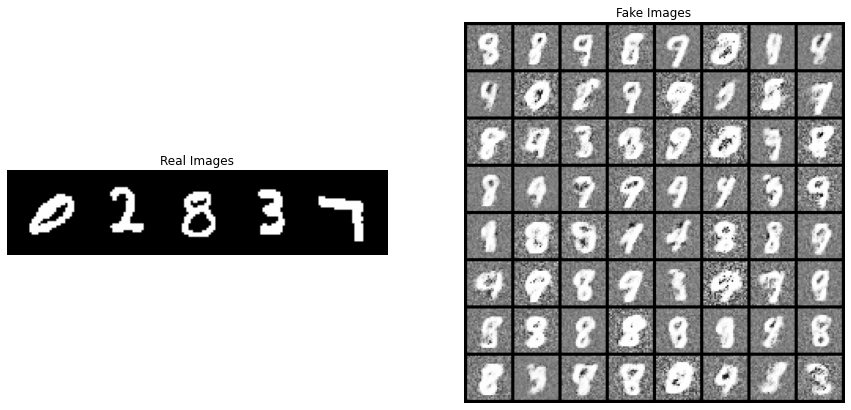

In [145]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:5], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Revocery Process

We extract a test set of images

In [130]:
m_list = [50,300,700] # nb measurements
n = 784 # input size

# Extract two images per class from the test
p = 2
lab = 0
count = 0
labels = []
images = []
for (image, label) in test_loader.dataset:
        
    if label==lab:
        labels.append(label)
        images.append(image)
        count+=1
            
    if count==p:
        lab+=1
        count=0

## Lasso

In [167]:
out_bp = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_bp[i].append(generate_bp(m, n, images[j].view(28*28,1)))

100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


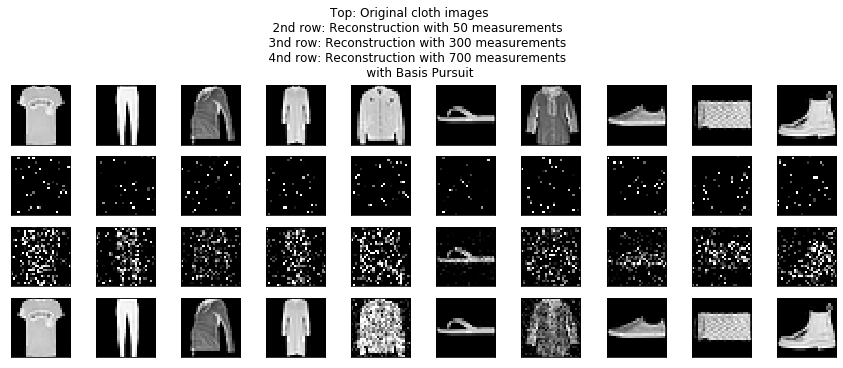

In [168]:
plot_recovery(images,out_bp,m_list, name="Basis Pursuit")

In [165]:
alpha=[0.00005,0.0000001,0.000000003]

out_lasso = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_lasso[i].append(generate_lasso(m, n, images[j].view(28*28,1), alpha[i]))

100%|██████████| 20/20 [00:01<00:00, 13.60it/s]


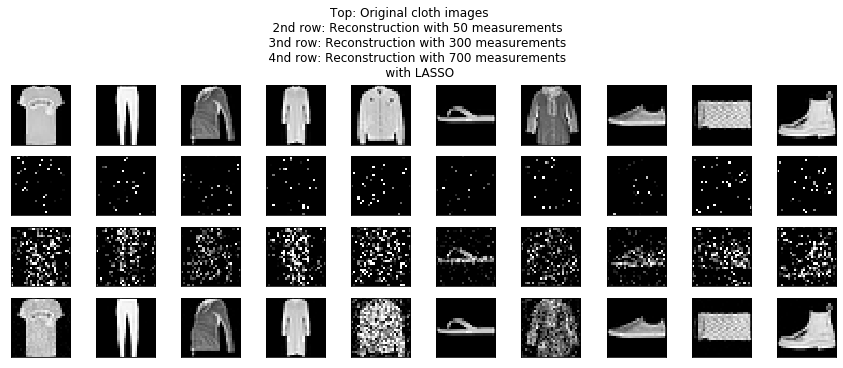

In [166]:
plot_recovery(images,out_lasso,m_list,name="LASSO")

## VAE

In [169]:
state_dict = torch.load('save/vae_fashion_z100.pth', map_location=device)
model = VAE(100).to(device)
model.load_state_dict(state_dict)
model = model.eval()

In [170]:
out_vae_fc_noreg = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_vae_fc_noreg[i].append(generate(model,device, m, n,100, images[j].view(28*28,1).to(device), regularization=0.))

100%|██████████| 20/20 [03:07<00:00,  9.37s/it]


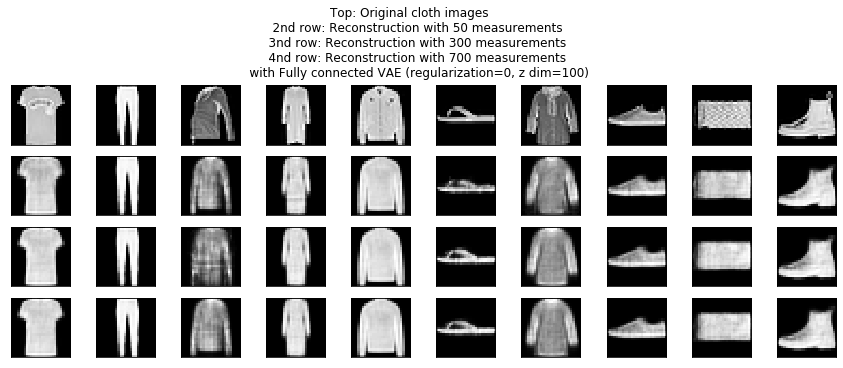

In [171]:
plot_recovery(images,out_vae_fc_noreg,m_list,"Fully Connected VAE (regularization=0, z dim=100)")

In [172]:
out_vae_fc_reg = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_vae_fc_reg[i].append(generate(model,device, m, n,100, images[j].view(28*28,1).to(device), regularization=0.1))

100%|██████████| 20/20 [03:06<00:00,  9.32s/it]


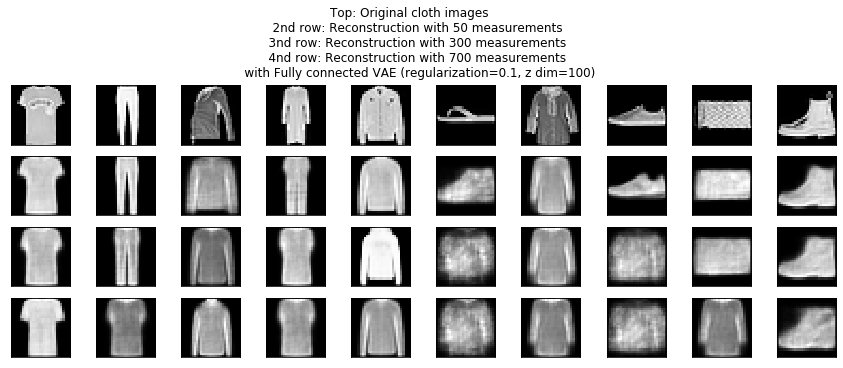

In [173]:
plot_recovery(images,out_vae_fc_reg,m_list,"Fully Connected VAE (regularization=0.1, z dim=100)")

In [174]:
state_dict = torch.load("save/vae_cnn_fashion_z100.pth", map_location=device)
model = VAEcnn(100).to(device)
model.load_state_dict(state_dict)
model = model.eval()

In [175]:
out_vae_cnn_noreg = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_vae_cnn_noreg[i].append(generate(model,device, m, n,100, images[j].view(28*28,1).to(device), regularization=0.))

100%|██████████| 20/20 [04:55<00:00, 14.80s/it]


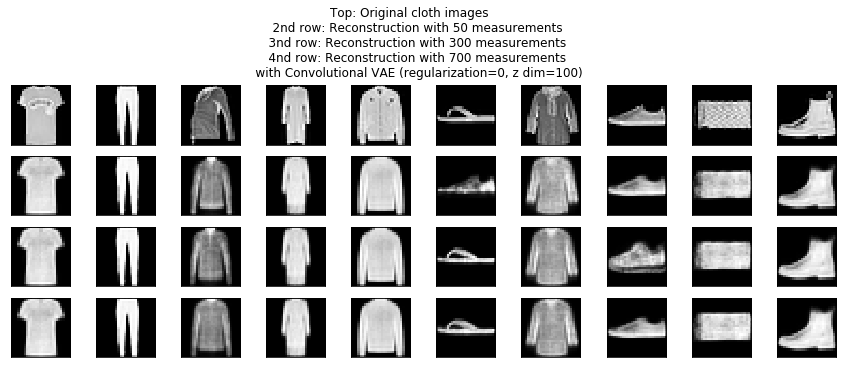

In [176]:
plot_recovery(images,out_vae_cnn_noreg,m_list,"Convolutional VAE (regularization=0, z dim=100)")

In [177]:
out_vae_cnn_reg = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_vae_cnn_reg[i].append(generate(model,device, m, n,100, images[j].view(28*28,1).to(device), regularization=0.1))

100%|██████████| 20/20 [04:52<00:00, 14.64s/it]


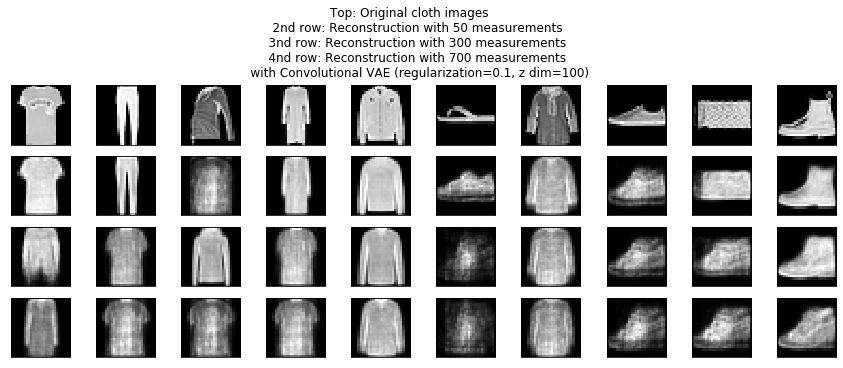

In [178]:
plot_recovery(images,out_vae_cnn_reg,m_list,"Convolutional VAE (regularization=0.1, z dim=100)")

## Sparse-VAE

In [179]:
state_dict = torch.load('save/vae_fashion_z100.pth', map_location=device)
model = VAE(100).to(device)
model.load_state_dict(state_dict)
model = model.eval()

In [180]:
out_vae_fc_sparse = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_vae_fc_sparse[i].append(generate_sparse(model,device, m, n,100, images[j].view(28*28,1).to(device)))

100%|██████████| 20/20 [03:24<00:00, 10.23s/it]


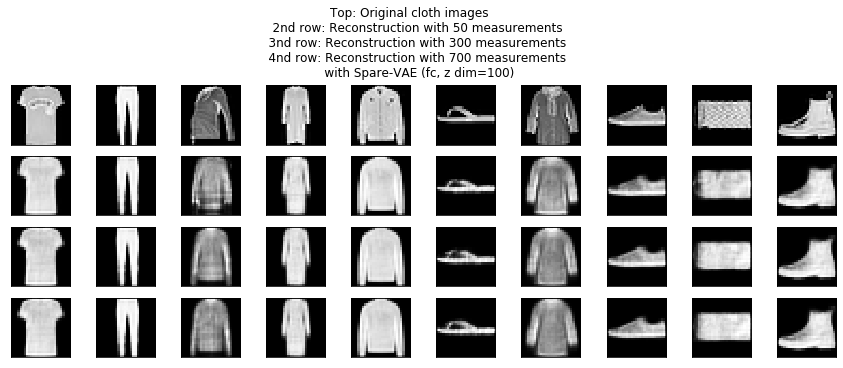

In [183]:
plot_recovery(images,out_vae_fc_sparse,m_list,"Sparse-VAE (fc, z dim=100)")

In [184]:
state_dict = torch.load("save/vae_cnn_fashion_z100.pth", map_location=device)
model = VAEcnn(100).to(device)
model.load_state_dict(state_dict)
model = model.eval()

In [185]:
out_vae_cnn_sparse = [[],[],[]]
for i,m in enumerate(m_list):
    for j in tqdm(range(len(images)),position=0):
        out_vae_cnn_sparse[i].append(generate_sparse(model,device, m, n,100, images[j].view(28*28,1).to(device)))

100%|██████████| 20/20 [05:10<00:00, 15.51s/it]


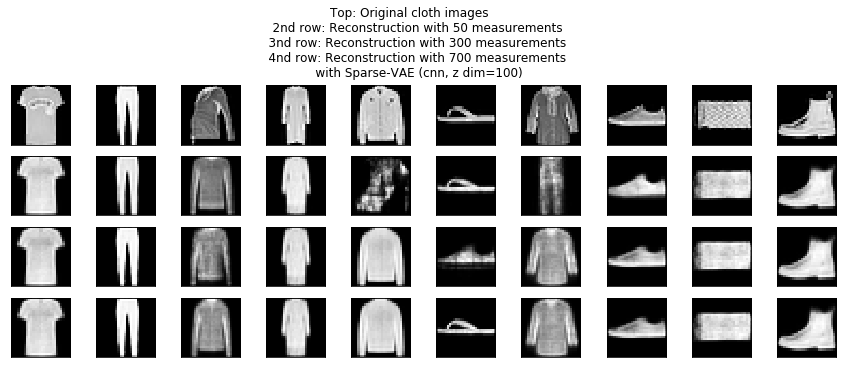

In [186]:
plot_recovery(images,out_vae_cnn_sparse,m_list,"Sparse-VAE (cnn, z dim=100)")

## DCS

As mentioned in our report we failed to obtain counvincing results using the Deep Compressed Sensing framework. In the next cell we see that the reconstruction are "collapsed" the are all the same.

In [219]:
#state_dict = torch.load('DCS1.pth',map_location=torch.device('cpu'))
#netDCS1 = Generator(ngpu)
#netDCS1.load_state_dict(state_dict)
#netDCS1.eval()
#out_DCS1 = []
#for i in tqdm(range(len(images))):
#    out_DCS1.append(generate(netDCS1.cuda(),m, n, images[i].view(28*28,1).to(device),regularization=True))

#plot_recovery(out_DCS1,m)
#get_score(out_DCS1,testset=test_mnist)

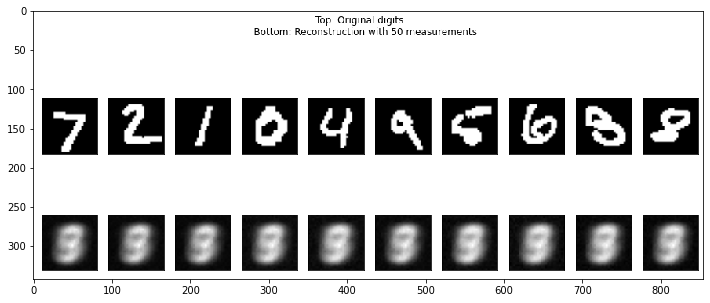

In [223]:
import matplotlib.image as mpimg
img=mpimg.imread('results/dcs.png')
plt.figure(figsize=(12,7))
imgplot = plt.imshow(img)
plt.show()

## Results

Look at the report for an analysis of the results.

In [194]:
vector = [out_bp,
          out_lasso,
          out_vae_fc_reg,
          out_vae_fc_noreg,
          out_vae_cnn_reg,
          out_vae_cnn_reg,
          out_vae_fc_sparse,
          out_vae_cnn_sparse,
         ]

pickle.dump(vector, open("save/pred.pk", "wb"))

In [216]:
scores = {"m=50":[get_score(out_bp[0],images),
              get_score(out_lasso[0],images),
              get_score(out_vae_fc_reg[0],images),
              get_score(out_vae_fc_noreg[0],images),
              get_score(out_vae_cnn_reg[0],images),
              get_score(out_vae_cnn_noreg[0],images),
              get_score(out_vae_fc_sparse[0],images),
              get_score(out_vae_cnn_sparse[0],images),],
          "m=300":[get_score(out_bp[1],images),
              get_score(out_lasso[1],images),
              get_score(out_vae_fc_reg[1],images),
              get_score(out_vae_fc_noreg[1],images),
              get_score(out_vae_cnn_reg[1],images),
              get_score(out_vae_cnn_reg[1],images),
              get_score(out_vae_fc_sparse[1],images),
              get_score(out_vae_cnn_sparse[1],images),],
          "m=700":[get_score(out_bp[2],images),
              get_score(out_lasso[2],images),
              get_score(out_vae_fc_reg[2],images),
              get_score(out_vae_fc_noreg[2],images),
              get_score(out_vae_cnn_reg[2],images),
              get_score(out_vae_cnn_reg[2],images),
              get_score(out_vae_fc_sparse[2],images),
              get_score(out_vae_cnn_sparse[2],images),],
         }

idx = ["Basis Pursuit",
       "LASSO",
       "VAE reg=0.1 (fc)",
       "VAE reg=0 (fc)",
       "VAE reg=0.1 (cnn)",
       "VAE reg=0, (cnn)",
       "Sparse-VAE (fc)",
       "Sparse-VAE (cnn)"]

#df = pd.DataFrame(scores,idx)
#pickle.dump(df, open("save/scores.pk", "wb"))

In [217]:
df = pickle.load(open("save/scores.pk", "rb"))
df

,m=50,m=300,m=700
Basis Pursuit,0.197316,0.141270,0.010251
LASSO,0.197908,0.136915,0.010131
VAE reg=0.1 (fc),0.023475,0.051690,0.075682
VAE reg=0 (fc),0.009879,0.007643,0.007189
VAE reg=0.1 (cnn),0.025307,0.051965,0.076860
"VAE reg=0, (cnn)",0.011150,0.051965,0.076860
Sparse-VAE (fc),0.010684,0.007541,0.007273
Sparse-VAE (cnn),0.043342,0.009443,0.008696
